In [12]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Parameter seting
S0_values = {"ATM": 100.0, "OTM": 90.0, "ITM": 110.0}  # original value from prof in office hour setting
r = 0.05  # rf
q = 0.07  # divident rate
sigma = 0.20  # valitility
T = 0.5  
K = 100.0  # exercise
N_values = [10, 50, 100, 200] 
num_simulations = 1000000  # the num of mento carlo simulation path for about 10^6



In [11]:

### Part A
#  close-form formula for geometric Asian option
def geometric_asian_closed_form(S0, K, r, q, sigma, T, N):
    dt = T / N 
    mu_G = np.log(S0) + (r - q - 0.5 * sigma**2) * T * (N + 1) / (2 * N)  
    var_G = (sigma**2 * T * (N + 1) * (2 * N + 1)) / (6 * N**2)  
    std_G = np.sqrt(var_G)  

    d1 = (mu_G - np.log(K) + var_G) / std_G  
    d2 = d1 - std_G  

    price = np.exp(-r * T) * (np.exp(mu_G + 0.5 * var_G) * norm.cdf(d1) - K * norm.cdf(d2))
    return price

#  MC - Geometric average

def monte_carlo_geometric_asian(S0, K, r, q, sigma, T, N, num_simulations):
    dt = T / N  
    drift = (r - q - 0.5 * sigma**2) * dt  
    sigma_sqrt_dt = sigma * np.sqrt(dt)  
    Z = np.random.normal(size=(num_simulations, N))

    log_returns = drift + sigma_sqrt_dt * Z
    log_prices = np.log(S0) + np.cumsum(log_returns, axis=1)

    log_geo_avg = np.mean(log_prices, axis=1)
    S_geo = np.exp(log_geo_avg)

    payoff = np.maximum(S_geo - K, 0)
    price = np.exp(-r * T) * np.mean(payoff)
    std_err = np.exp(-r * T) * np.std(payoff) / np.sqrt(num_simulations)
    conf_interval = (price - 1.96 * std_err, price + 1.96 * std_err)  # 95% CI

    return price, conf_interval


Results for ATM:

  N  True Price  MC(Geometric) MC(Geometric) CI
 10    3.064865       3.067751 (3.0580, 3.0775)
 50    2.894611       2.902624 (2.8934, 2.9119)
100    2.873313       2.870161 (2.8610, 2.8793)
200    2.862662       2.860168 (2.8511, 2.8693)


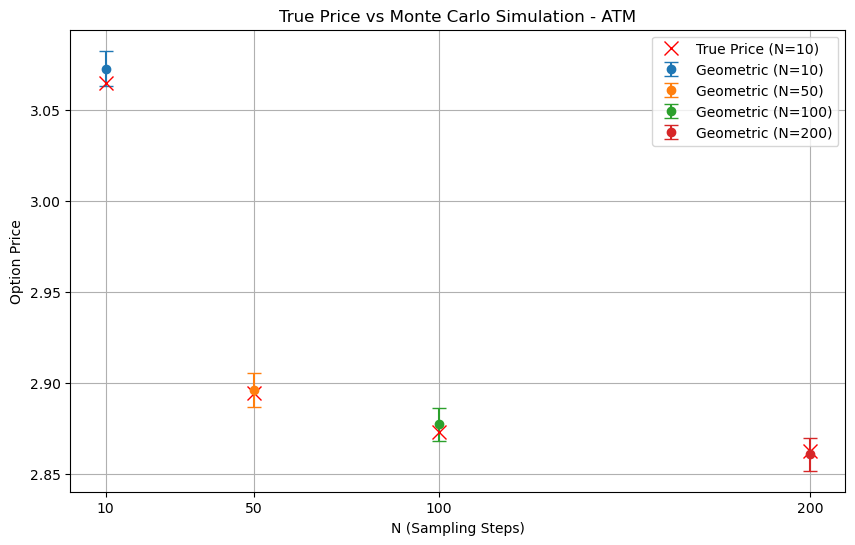


Results for OTM:

  N  True Price  MC(Geometric) MC(Geometric) CI
 10    0.382255       0.381315 (0.3781, 0.3845)
 50    0.310340       0.312614 (0.3098, 0.3154)
100    0.301802       0.303826 (0.3011, 0.3066)
200    0.297571       0.298239 (0.2955, 0.3010)


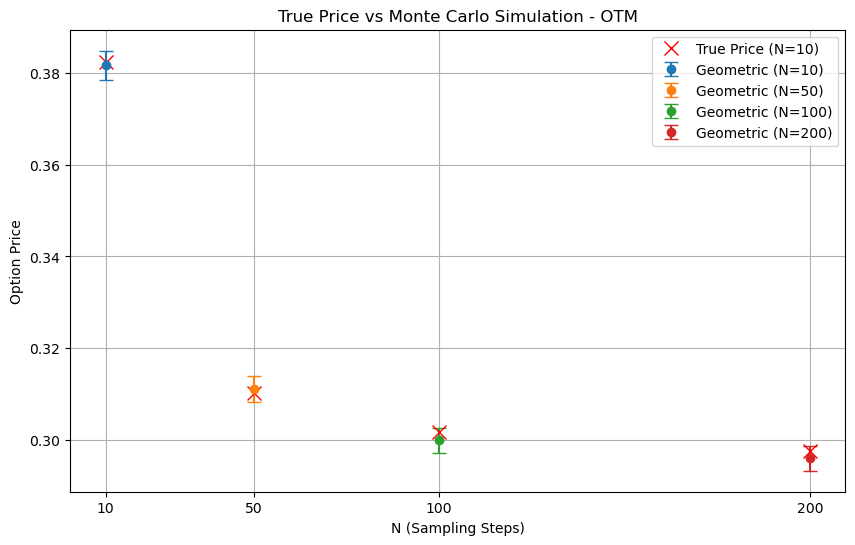


Results for ITM:

  N  True Price  MC(Geometric) MC(Geometric) CI
 10    9.726860       9.729474 (9.7133, 9.7457)
 50    9.646177       9.637854 (9.6224, 9.6533)
100    9.636772       9.642293 (9.6269, 9.6577)
200    9.632128       9.636552 (9.6212, 9.6519)


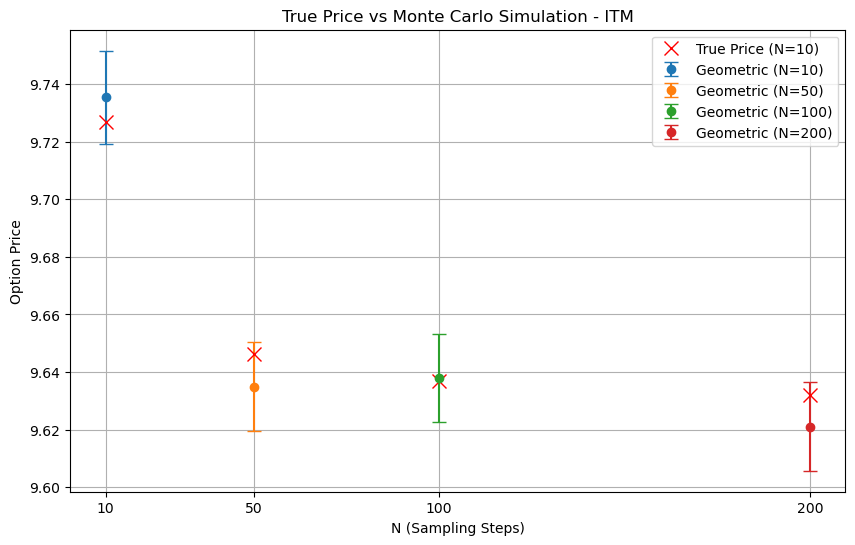

In [10]:
for case, S0 in S0_values.items():
    results = []
    for N in N_values:
        true_price = geometric_asian_closed_form(S0, K, r, q, sigma, T, N)
        mc_geo_price, mc_geo_ci = monte_carlo_geometric_asian(S0, K, r, q, sigma, T, N, num_simulations)

        results.append({
            'N': N,
            'True Price': true_price,
            'MC(Geometric)': mc_geo_price,
            'MC(Geometric) CI': f"({mc_geo_ci[0]:.4f}, {mc_geo_ci[1]:.4f})"
        })

    df = pd.DataFrame(results)
    print(f"\nResults for {case}:\n")
    print(df.to_string(index=False))


    plt.figure(figsize=(10, 6))
    for N in N_values:
        true_price = geometric_asian_closed_form(S0, K, r, q, sigma, T, N)
        mc_geo_price, mc_geo_ci = monte_carlo_geometric_asian(S0, K, r, q, sigma, T, N, num_simulations)

        plt.errorbar(N, mc_geo_price, yerr=[[mc_geo_price - mc_geo_ci[0]], [mc_geo_ci[1] - mc_geo_price]],
                     fmt='o', capsize=5, label=f'Geometric (N={N})')
        plt.plot(N, true_price, 'rx', markersize=10, label=f'True Price (N={N})' if N == N_values[0] else "")

       
    plt.xlabel('N (Sampling Steps)')
    plt.ylabel('Option Price')
    plt.title(f'True Price vs Monte Carlo Simulation - {case}')
    plt.xticks(N_values)
    plt.legend()
    plt.grid(True)
    plt.show()

### Conclusion: As shown in figure, Small N has Larger absolute errors.Wider confidence intervals due to fewer averaging points, increasing path discretization error.
### A larger N reduces the discrete error and tightens the confidence interval. For N≥100, the Monte Carlo estimator is very close to the closed-form formula solution. 

In [5]:
### Part B
# MC - Arithmetic average

def monte_carlo_arithmetic_asian(S0, K, r, q, sigma, T, N, num_simulations):
    dt = T / N  
    drift = (r - q - 0.5 * sigma**2) * dt  
    sigma_sqrt_dt = sigma * np.sqrt(dt)  
    Z = np.random.normal(size=(num_simulations, N))

    log_returns = drift + sigma_sqrt_dt * Z
    log_prices = np.log(S0) + np.cumsum(log_returns, axis=1)
    prices = np.exp(log_prices)

    S_arith = np.mean(prices, axis=1)

    payoff = np.maximum(S_arith - K, 0)
    price = np.exp(-r * T) * np.mean(payoff)
    std_err = np.exp(-r * T) * np.std(payoff) / np.sqrt(num_simulations)
    conf_interval = (price - 1.96 * std_err, price + 1.96 * std_err)  # 95% CI

    return price, conf_interval


Results for ATM:

  N  True Price  MC(Arithmetic) MC(Arithmetic) CI
 10    3.064865        3.134174  (3.1242, 3.1441)
 50    2.894611        2.964975  (2.9556, 2.9744)
100    2.873313        2.954959  (2.9456, 2.9643)
200    2.862662        2.936715  (2.9274, 2.9460)


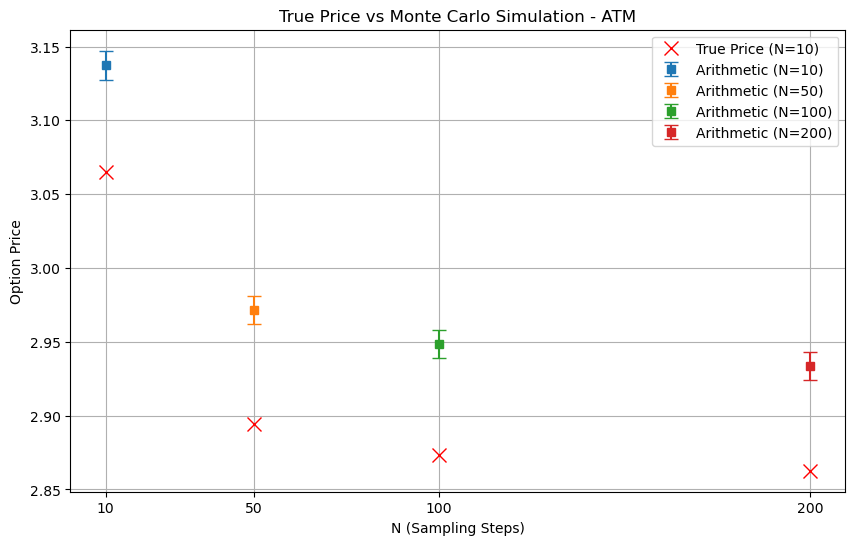


Results for OTM:

  N  True Price  MC(Arithmetic) MC(Arithmetic) CI
 10    0.382255        0.405025  (0.4017, 0.4084)
 50    0.310340        0.337153  (0.3342, 0.3401)
100    0.301802        0.325077  (0.3222, 0.3280)
200    0.297571        0.321570  (0.3187, 0.3244)


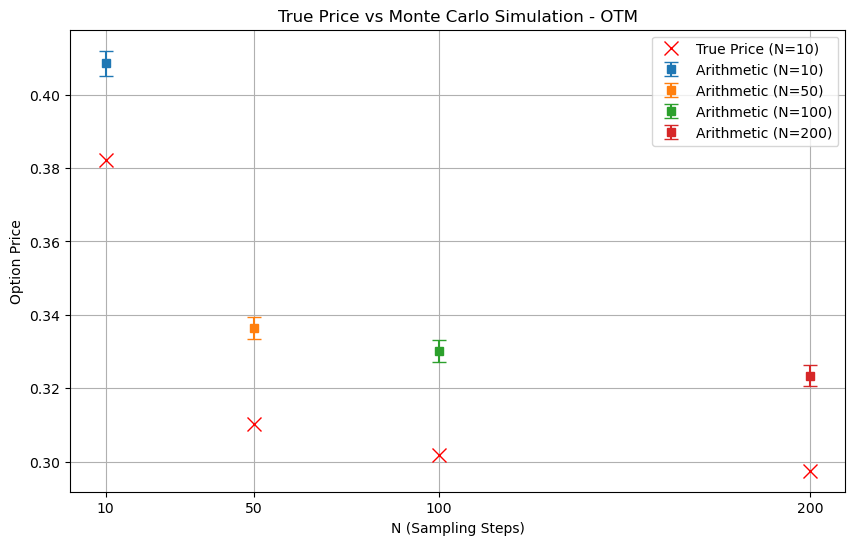


Results for ITM:

  N  True Price  MC(Arithmetic) MC(Arithmetic) CI
 10    9.726860        9.868960  (9.8526, 9.8853)
 50    9.646177        9.768661  (9.7530, 9.7843)
100    9.636772        9.785022  (9.7694, 9.8006)
200    9.632128        9.772455  (9.7569, 9.7880)


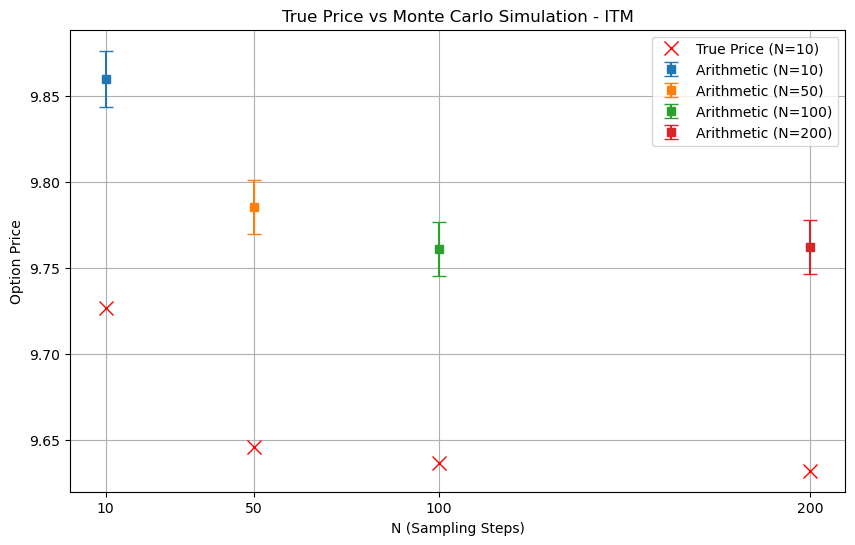

In [14]:
for case, S0 in S0_values.items():
    results = []
    for N in N_values:
        true_price = geometric_asian_closed_form(S0, K, r, q, sigma, T, N)
        mc_geo_price, mc_geo_ci = monte_carlo_geometric_asian(S0, K, r, q, sigma, T, N, num_simulations)
        mc_arith_price, mc_arith_ci = monte_carlo_arithmetic_asian(S0, K, r, q, sigma, T, N, num_simulations)

        results.append({
            'N': N,
            'True Price': true_price,
            'MC(Arithmetic)': mc_arith_price,
            'MC(Arithmetic) CI': f"({mc_arith_ci[0]:.4f}, {mc_arith_ci[1]:.4f})"
        })

    df = pd.DataFrame(results)
    print(f"\nResults for {case}:\n")
    print(df.to_string(index=False))

    plt.figure(figsize=(10, 6))
    for N in N_values:
        true_price = geometric_asian_closed_form(S0, K, r, q, sigma, T, N)
        mc_arith_price, mc_arith_ci = monte_carlo_arithmetic_asian(S0, K, r, q, sigma, T, N, num_simulations)

        plt.plot(N, true_price, 'rx', markersize=10, label=f'True Price (N={N})' if N == N_values[0] else "")

        plt.errorbar(N, mc_arith_price, yerr=[[mc_arith_price - mc_arith_ci[0]], [mc_arith_ci[1] - mc_arith_price]],
                     fmt='s', capsize=5, label=f'Arithmetic (N={N})')

    plt.xlabel('N (Sampling Steps)')
    plt.ylabel('Option Price')
    plt.title(f'True Price vs Monte Carlo Simulation - {case}')
    plt.xticks(N_values)
    plt.legend()
    plt.grid(True)
    plt.show()


Results for ATM:

  N  True Price  MC(Geometric) MC(Geometric) CI  MC(Arithmetic) MC(Arithmetic) CI
 10    3.064865       3.061245 (3.0515, 3.0710)        3.134923  (3.1250, 3.1449)
 50    2.894611       2.888368 (2.8792, 2.8976)        2.968835  (2.9594, 2.9782)
100    2.873313       2.877273 (2.8681, 2.8864)        2.954600  (2.9452, 2.9640)
200    2.862662       2.861880 (2.8528, 2.8710)        2.938193  (2.9289, 2.9475)


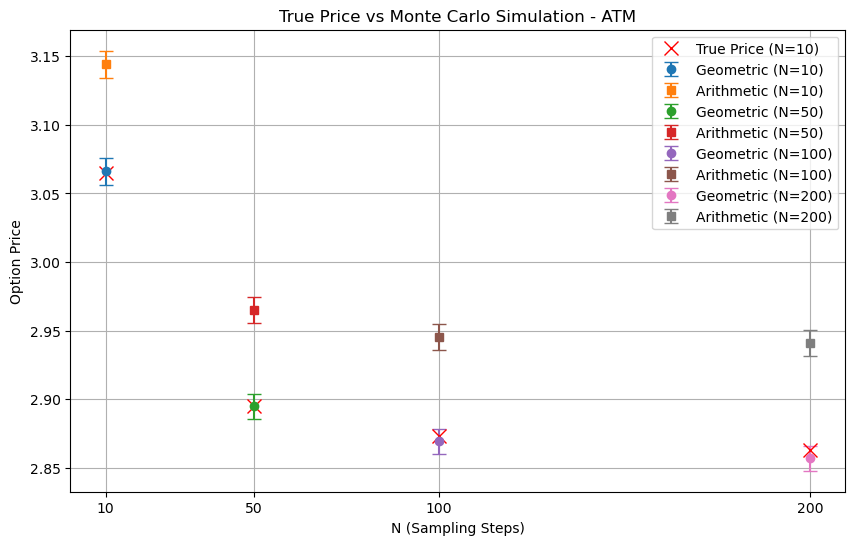


Results for OTM:

  N  True Price  MC(Geometric) MC(Geometric) CI  MC(Arithmetic) MC(Arithmetic) CI
 10    0.382255       0.381948 (0.3787, 0.3852)        0.408957  (0.4056, 0.4123)
 50    0.310340       0.312375 (0.3096, 0.3152)        0.334593  (0.3316, 0.3375)
100    0.301802       0.300740 (0.2980, 0.3035)        0.325915  (0.3230, 0.3288)
200    0.297571       0.297581 (0.2949, 0.3003)        0.320338  (0.3175, 0.3232)


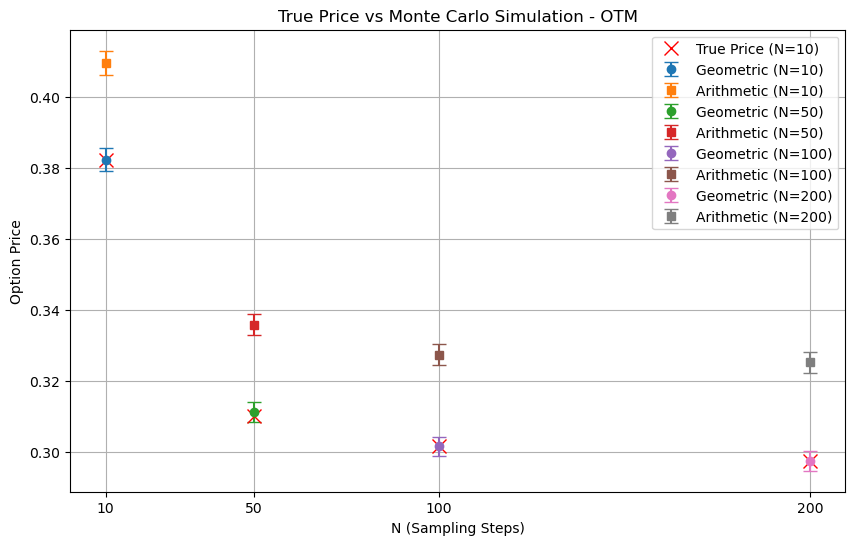


Results for ITM:

  N  True Price  MC(Geometric) MC(Geometric) CI  MC(Arithmetic) MC(Arithmetic) CI
 10    9.726860       9.732182 (9.7159, 9.7484)        9.863950  (9.8476, 9.8803)
 50    9.646177       9.637562 (9.6221, 9.6531)        9.789585  (9.7739, 9.8052)
100    9.636772       9.637597 (9.6222, 9.6530)        9.765731  (9.7502, 9.7813)
200    9.632128       9.636149 (9.6208, 9.6515)        9.764453  (9.7489, 9.7800)


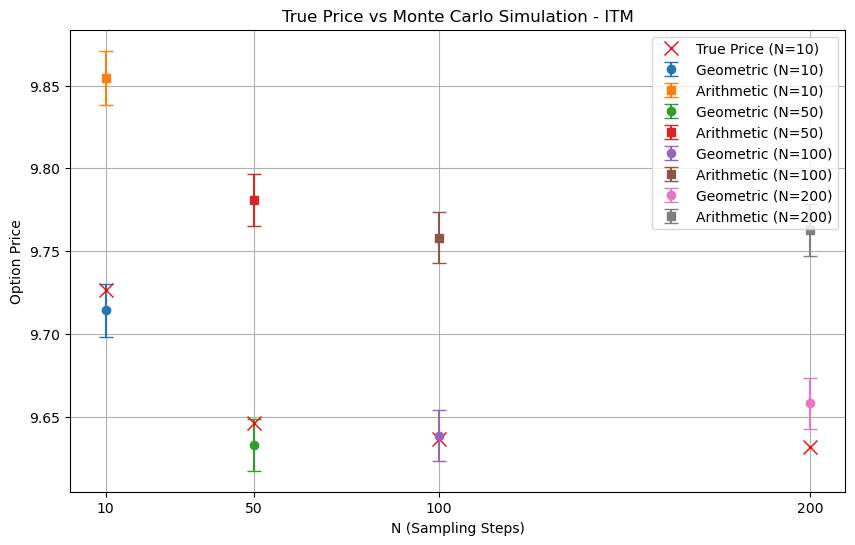

In [15]:
for case, S0 in S0_values.items():
    results = []
    for N in N_values:
       
        true_price = geometric_asian_closed_form(S0, K, r, q, sigma, T, N)

        mc_geo_price, mc_geo_ci = monte_carlo_geometric_asian(S0, K, r, q, sigma, T, N, num_simulations)

        mc_arith_price, mc_arith_ci = monte_carlo_arithmetic_asian(S0, K, r, q, sigma, T, N, num_simulations)

        results.append({
            'N': N,
            'True Price': true_price,
            'MC(Geometric)': mc_geo_price,
            'MC(Geometric) CI': f"({mc_geo_ci[0]:.4f}, {mc_geo_ci[1]:.4f})",
            'MC(Arithmetic)': mc_arith_price,
            'MC(Arithmetic) CI': f"({mc_arith_ci[0]:.4f}, {mc_arith_ci[1]:.4f})"
        })

    df = pd.DataFrame(results)
    print(f"\nResults for {case}:\n")
    print(df.to_string(index=False))

    plt.figure(figsize=(10, 6))
    for N in N_values:
        true_price = geometric_asian_closed_form(S0, K, r, q, sigma, T, N)
        mc_geo_price, mc_geo_ci = monte_carlo_geometric_asian(S0, K, r, q, sigma, T, N, num_simulations)
        mc_arith_price, mc_arith_ci = monte_carlo_arithmetic_asian(S0, K, r, q, sigma, T, N, num_simulations)

        plt.errorbar(N, mc_geo_price, yerr=[[mc_geo_price - mc_geo_ci[0]], [mc_geo_ci[1] - mc_geo_price]],
                     fmt='o', capsize=5, label=f'Geometric (N={N})')
        plt.plot(N, true_price, 'rx', markersize=10, label=f'True Price (N={N})' if N == N_values[0] else "")

        plt.errorbar(N, mc_arith_price, yerr=[[mc_arith_price - mc_arith_ci[0]], [mc_arith_ci[1] - mc_arith_price]],
                     fmt='s', capsize=5, label=f'Arithmetic (N={N})')

    plt.xlabel('N (Sampling Steps)')
    plt.ylabel('Option Price')
    plt.title(f'True Price vs Monte Carlo Simulation - {case}')
    plt.xticks(N_values)
    plt.legend()
    plt.grid(True)
    plt.show()

### Conclusion: As shown in figure, Arithmetic MC prices are consistently higher than geometric closed-form prices across all scenarios due to higher volatility. As N increases, Arithmetic MC prices are also higher than geometric closed-form prices.